# Inversion and Optimisation <a class="tocSkip"></a>

# Homework Lecture 4 <a class="tocSkip"></a>

# Image Processing

As we saw in today's lecture the discrete Laplace operator can be used for smoothening of images, where if we apply the following matrix:

$$
I - \tfrac 14 q \underline{\mathbf A}
$$

where $\underline{\mathbf A}$ is the discrete Laplace operator with the familiar $4, -1, -1, -1, -1$ coefficients. The value of $q$ should be between 0 and 1, but $q=4/5$ gives the natural averaging over all 5 points in the stencil. You would apply this matrix to a vector $\boldsymbol{c}$ which is the flattened version of the image in one long vector, meaning that if our matrix is $N_y\times N_x$, the length of the vector is $n=N_x N_y$ and thus the matrix is $n \times n = N_xN_y\times N_xN_y$. As you can imagine this rapidly gives very large systems for high resolution matrices.

To read in an image in the form of a flattened vector you can use:

In [13]:
import matplotlib.pyplot as plt
# reads in an image of Ny x Nx x 3
# where the last dimension represent three RGB colour channels
img = plt.imread('figures/exhibition_road.jpg')

# to make things easier, let's just deal with black
# which we can do by averaging over the 3 channels:
img_bw = img.sum(axis=-1)/3

# also to make the problem a little smaller
# let's subsample the img: "::2" means we are only
# every other row and column of the original image
img_bw = img_bw[::2, ::2]

c = img_bw.flatten()
print(img.shape, img_bw.shape, c.shape)

(958, 1704, 3) (479, 852) (408108,)


To display the corresponding image we have to reshape the flat vector back into $p\times q$ form:

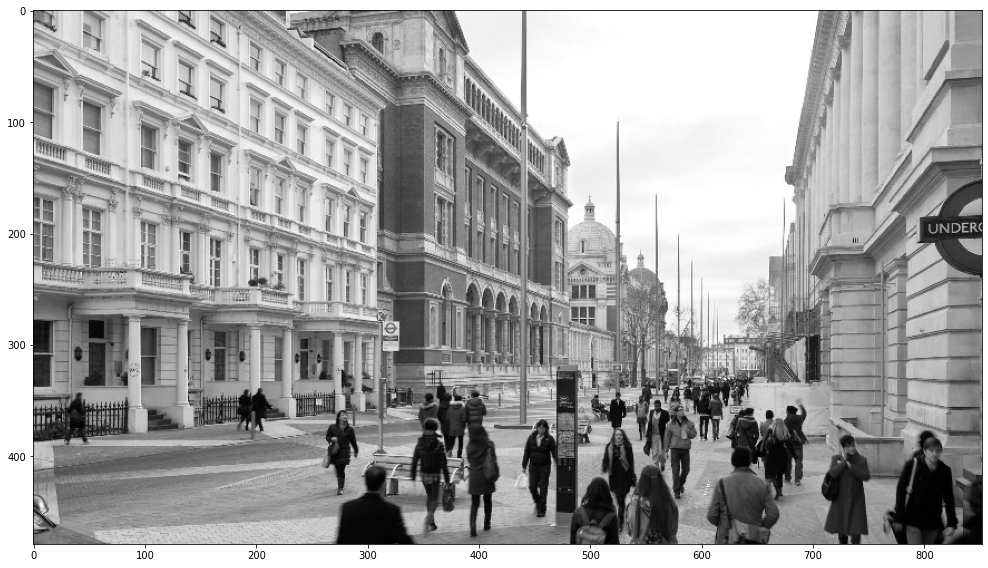

In [14]:
fig, ax = plt.subplots(1,1, figsize=(17,10))
ax.imshow(c.reshape(img_bw.shape), cmap='gray');

Finally you can use the following piece of code to obtain the discrete Laplace operator (here with Neumann boundary conditions):

In [16]:
import numpy as np
import scipy.sparse as sp

def Laplace(Nx, Ny):
    """ Assembles a discrete Laplace operator with Neumann boundary conditions
    into a sparse matrix.
    """
    # construct matrix from 5 (off-)diagonals
    # we provide the diagonals as one 5 x n array
    # the actual off-diagonals should of course be shorter
    # but dia_matrix cuts them off for us
    n = Nx*Ny
    offsets = [-Nx, -1, 0, 1, Nx]
    diags = -np.ones((5,n))
    diags[2] = -diags[2]*4  # main diagonal should be positive and 4 times the off-diagonals
    A = sp.dia_matrix((diags, offsets), shape=(n,n)).tocsr()
    
    # grid point in the right-most column, should not be connected to
    # the grid point in the first column on the next row
    for i in range(1,Ny):
        A[i*Nx-1, i*Nx] = 0
        A[i*Nx, i*Nx-1] = 0
        
    # for homogenous Neumann boundary conditions all we have to do is
    # make sure that the diagonal is set such that the row sum is zero
    # This replaces some of the 4 values on the diagonal with the actual number
    # of connected grid points on the boundary:
    A.setdiag(A.diagonal() - np.array(A.sum(axis=1)).flatten())
    
    return A

# Note the ordering of the dimensions of the image:
# first dimension img.shape[0] is the number of rows (y-direction)
# second dimension img.shape[1] is the number of columns (x-direction)
A = Laplace(img_bw.shape[1], img_bw.shape[0])

* Apply a smoothing step a few times on the image (or any other image you wish). You may need to apply the smoothing step a few times to actually notice the effect.

* As was mentioned in the lecture we can also use the operator $\underline{\mathbf A}$ by itself to detect sharp gradients in the image (edge detection). Try this out on the image - the result is best displayed by taking the absolute value of the vector.

* As you have noticed the smoothing effect is quite slow to spread. As explained in the lecture a stronger effect can be achieved in a single step by solving:
$$
\left(\underline{\mathbf I} + \tfrac 14 q \underline{\mathbf A}\right) \boldsymbol{c}^{k+1} = \boldsymbol{c}^k
$$
Try this out for different values of $q$, including some very high values. What linear solver algorithm can you use here and why?

# Krylov Subspace
Consider the following matrix

$$
\underline{\mathbf A} =
\begin{pmatrix}
  0 & 0 & 1 \\
  1 & 0 & 0 \\
  0 & 1 & 0
\end{pmatrix}
$$

* Using the right-hand side vector $\boldsymbol{b}=(1, 0, 0)^T$ for the linear system $\underline{\mathbf A}\boldsymbol{x}=\boldsymbol{b}$ with an initial guess of $\boldsymbol{x}_0 = (0,0,0)^T$ construct the Krylov subspaces $\mathcal{D}_0, \mathcal{D}_1$ and $\mathcal{D}_2$

* In the lecture you have learnt that for GMRES at the end of each iteration $k$ we have $\boldsymbol{x}^{(k)} - \boldsymbol{x}^{(0)} \in \mathcal{D}_{k-1}$. Use the following bit of code to run scipy's gmres routine for exactly k iterations (or earlier when converged) and check that this is indeed the case. The exact answer is $\boldsymbol{x}^\ast = (0, 0, 1)$. Can you explain the number of iterations that is required to reach it?

* Repeat the same two questions for initial guesses $\boldsymbol{x}_0=(1,0,0)$, $\boldsymbol{x}_0=(0,1,0)$, $\boldsymbol{x}_0=(0,0,1)$, i.e. for each of these initial guesses:
  - construct the Krylov subspaces
  - predict the number of required iterations

# Airfoils and Shape Optimisation <a class="tocSkip"></a>
This is the first part of a three part tutorial that takes you through the shape optimisation of an airfoil, in which we try to optimise its shape to maximise its lift force. This part explains how we can compute the flow around an airfoil using different discretisation methods. These lead to linear discretised systems, which require the linear solver algorithms explained in lecture 3 and 4 to solve them efficiently.

In [ ]:
# needs to be in separate cell!
%matplotlib inline

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as sl
import scipy.sparse as sp
import scipy.sparse.linalg as spl
import triangle
from matplotlib.tri import Triangulation, LinearTriInterpolator

# ensure fonts in figures are readable:
plt.rcParams['font.size'] = 16
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'Dejavu Sans']

# this module is provided with the notebook (potential_flow.py)
# NOTE: you may will need to install the triangle python package
# which you can do by running !pip install triangle in your notebook
from potential_flow import *

# these two lines ensure that imported modules are automatically reloaded when changed
%load_ext autoreload
%autoreload 2

# A Potential Flow Solver

## Introduction
In fluid dynamics, the potential flow method writes the velocity field as a gradient of a scalar field $\phi$

$$
  {\bf u}({\bf x}) = \nabla \phi({\bf x})
$$

You may remember that this is only possible if the curl of the velocity field is zero:

$$
  {\bf\nabla}\times {\bf u}({\bf x}) = 0
$$

which means that the potential flow approximation is not valid in flows where rotational effects (vorticity) are important, for instance in boundary layers or wakes. The approximation is however still applicable in many other areas. One area where potential flow is often used is in aerodynamics, to describe the flow around an aircraft (away from the boundary layer).

We further assume that the flow is incompressible, i.e. $\nabla\cdot{\bf u}=0$.
In the context of aerodynamics the assumption of incompressibility applies for low Mach number, i.e. we assume that velocities are small compared to the speed of sound. In this case,
we obtain the following equation for $\phi$:

$$
  \nabla\cdot{\bf u} = \nabla\cdot\nabla\phi({\bf x}) = \nabla^2 \phi({\bf x}) = 0,
$$

in other words $\phi$ is a solution to Laplace's equation! Since there are no terms in this equation that depend on anything in the interior of the domain, the solution is going to be determined entirely by the boundary conditions on $\phi$.

The boundary conditions can be used to enforce a normal velocity on the boundary. After all
the normal derivative of $\phi$ at the boundary is given by

$$
  {\bf n}\cdot\nabla \phi({\bf x}) = {\bf n}\cdot{\bf u}({\bf x}) = u_n
$$

where $u_n$ is the normal velocity we want to impose. This is a Neumann boundary condition for $\phi$. Thus
we solve the following problem:

$$
  \nabla^2 \phi({\bf x}) = 0 \;\; \text{subject to Neumann boundary condition:}\;\; {\bf n}\cdot\nabla \phi({\bf x})=u_n
$$

## Potential Flow Solver based on the Finite Element Method
We provide you with a piece of code that implements the finite element discretisation
of the equations above to solve the potential flow problem.

The `PotentialFlowFE` class (from the potential_flow.py module that comes with this tutorial) takes 5 pieces of information:
- the outside boundary (a polygon) of the domain we want to solve the potential flow in. This should be sufficiently far from the airfoil
- the interior boundary (another polygon) describing the airfoil
- the resolution (maximum triangle area) for the triangular mesh we use in the Finite Element Method
- the air speed `u_inf` relative to the airfoil
- the angle of the incoming air flow in radians: `alpha=0` means the air comes in straight from the left

In [ ]:
# polygon describing the outer boundary
outer_boundary = [[-2, -2], [3, -2], [3, 2], [-2, 2], [-2, -2]]

# polygon describing a NACA0012 airfoil
airfoil = np.loadtxt('naca0012.dat')

resolution = 1e-2  # maximum triangle area
u_inf = 1.0
alpha = np.deg2rad(4)
pf = PotentialFlowFE(airfoil, outer_boundary, resolution, u_inf, alpha)

As an intermediate step you can plot the mesh with:

In [ ]:
# plot the mesh
fig, ax = plt.subplots(figsize=(16,8))
pf.plot_mesh(ax)

To obtain the linear system associated with the finite element method, we run:

In [ ]:
A, b = pf.assemble(sparse=False)

Note that we have specified `sparse=False` which means that the matrix $\underline{\mathbf A}$ is stored as a dense matrix. The solution step is now simply (using the direct solver from scipy):

In [ ]:
phi = sl.solve(A, b)

or you can use any other method to solve the system. Finally, there is also a helper function to plot the solution:

In [ ]:
# and plot the solution:
plt.figure(figsize=(16,6))
pf.plot_solution(phi, scale=10)

# we zoom in a little bit, to have a better look at the flow around the trailing edge
plt.axis([0.5, 1.5, -0.5, 0.5]);

## Improving the solver
1. Investigate the matrix properties to see which iterative (Krylov) solution method we might 
use instead of a direct solver, e.g. Conjugate Gradient, GMRES or BiCGSTAB. You can use the implementations provided in `scipy.sparse.linalg` which handle both dense and sparse matrices. We have imported `scipy.sparse.linalg` as `spl`, so you can use `spl.cg`, `spl.gmres` or `spl.bicgstab`. For now let's stick with a fixed relative tolerance of $\epsilon_{\text{rel}}=10^{-5}$, via the `tol=` argument. Use `%timeit` to compare the direct method and your iterative method of choice. For example:

In [ ]:
%timeit phi = spl.gmres(A, b, tol=1e-5)

2. Now use sparse matrices by providing `sparse=True` to the `assemble()` method. Again compare the direct method (now using `spl.spsolve` instead of `sl.solve`) and the iterative method. Which one is faster?

## Preconditioners
In today's lecture, you have seen that preconditioners can be used to improve the conditioning of a matrix and thereby reduce the number of required iterations in Krylov methods, such as Conjugate Gradient, GMRES, BiCGStab, etc. Unfortunately scipy's linear algebra solvers do not offer much in terms of preconditioners. We have provided you here with three preconditioners: the Jacobi preconditioner, the SSOR method and an Algebraic Multigrid (AMG) preconditioner. The last two rely on an external python module called `pyamg` which again you can install via `pip install pyamg`.

In [ ]:
import pyamg

class Preconditioner(spl.LinearOperator):
    """A base class for the preconditioners
    
    Every preconditioner needs to implement a __call__ method
    that will be called with the residual vector and should return
    the preconditioner applied to that residual vector."""
    def __init__(self, A):
        super().__init__(dtype=None, shape=A.shape)

    def __call__(self, r):
        raise NotImplemented("The call method should be overloaded")

    def _matvec(self, r):
        return self(r)


class JacobiPreconditioner(Preconditioner):
    """Jacobi preconditioner"""
    def __init__(self, A):
        super().__init__(A)
        self.diag = A.diagonal()  # extract main diagonal

    def __call__(self, r):
        return r/self.diag


class SSORPreconditioner(Preconditioner):
    """SSOR preconditioner,
    
    set 0<omega<2 to improve convergence (see lecture notes 4)."""
    def __init__(self, A, omega=1.0):
        super().__init__(A)
        self.A = A
        self.rr = np.zeros(A.shape[0])  # auxilary vector
        self.omega = omega

    def __call__(self, r):
        self.rr[:] = 0  # reset to zero
        # this step computes rr = rr + M^{-1} r
        # since we start with rr = 0, we get rr = M^{-1} r back
        pyamg.relaxation.relaxation.sor(self.A, self.rr, r, omega=self.omega, sweep='symmetric')
        return self.rr

class AMGPreconditioner(Preconditioner):
    """AMG preconditioner - wraps around pyamg's ruge_stuben_solver"""
    def __init__(self, A):
        super().__init__(A)
        ml = pyamg.ruge_stuben_solver(sp.csr_matrix(A))
        self.gamg = ml.aspreconditioner()
        
    def __call__(self, r):
        return self.gamg(r)

The way to use these is as follows:

In [ ]:
A, b = pf.assemble(sparse=True)

jacobi = JacobiPreconditioner(A)
ssor = SSORPreconditioner(A, omega=1.5)
amg = AMGPreconditioner(A)

phi = spl.gmres(A, b, tol=1e-5, M=jacobi)
phi = spl.gmres(A, b, tol=1e-5, M=ssor)
phi = spl.gmres(A, b, tol=1e-5, M=amg)

3. Again compare the (sparse) direct method, now with your  preconditioned iterative method of choice.

## Counting the Number of Iterations <a class=tocSkip></a>
In your comparison, for a better understanding of what is going on, you should also look at the number of iterations that CG needs to reach the stopping criterion. Unfortunately this is not something that `spl.cg` returns directly. It does however allow you to provide a callback, a function that it will call every iteration. For this callback we will provide a SimpleCounter object based on the class below. It is an object that simply counts the number of times it has been called (ignoring any other arguments it may have been given):

In [ ]:
class SimpleCounter:
    """Simple counter object that records how many times it has been called"""
    def __init__(self):
        self.count = 0
    
    def __call__(self, *args):
        """Counts each call, ignore any arguments"""
        self.count += 1


# example usage:
counter = SimpleCounter()
counter()
counter("spurious argument", [1, 2, 3])
# we have called it twice now:
assert counter.count == 2

The way this is used in the solve is then as follows:

In [ ]:
counter = SimpleCounter()
phi = spl.gmres(A, b, tol=1e-5, callback=counter)
print("Iterations:", counter.count)

You should not combine this with `%timeit` however as the counter will accumulate over all the runs that `timeit` averages over. So do you timing in a separate call.

4. using your iterative method of choice, compare the number of iterations required with the three different preconditioners

5. Depending on your system you may have found that the best iterative method, even with preconditioning does not beat the direct method. What about if you increase the resolution? Make sure you increase the resolution by a considerable amount: change the maximum triangle area from `1e-2` to `5e-3`, `1e-3`, `5e-4`, `1e-4`, etc. Note that at some point you will run out of memory. If your results are still inconclusive for the resolutions that you can run, you may also draw conclusions based on extrapolation to argue about what would happen if you were able to run an even higher resolution case (say on a bigger computer).

6. Suppose you are thinking to extend the flow solver to 3D, based on your observations and what you know about the properties of the direct and the preconditioned iterative methods you are comparing, what are your expectations for what the fastest solution strategy will be in 3D?

**NOTE:** The following section is for background purposes only, which motivatives the use of a different solver `KuttaPotentialFlowFE` which can compute lift - as opposed to `PotentialFlowFE` for reasons explained below. You can safely skip this section entirely and  move on to the questions in the next section.

# Background: Lift and Point Vortices
There is still one important bit of physics missing from our potential flow solver. We want to compute the lift, the component of the force that the flow exerts on the airfoil that is orthogonal to the incoming flow direction. It is this force that holds a plane up. We can compute it using the [Kutta Joukowski theorem](https://en.wikipedia.org/wiki/Kutta%E2%80%93Joukowski_theorem): If we compute the circulation of ${\bf u}$ around the airfoil (described by a contour $C$):

$$
  \Gamma = \oint_C {\bf u}\cdot\mathrm{d}{\bf s}
$$

(note the $\cdot\mathrm{d}{\bf s}$ means we are integrating the tangential component of velocity around the airfoil), then the lift per unit span is given by:

$$
  L = -\rho \|{\bf u}_\infty\| \Gamma,
$$

where $\rho$ is the air density, and ${\bf u}_\infty$ the upstream velocity.

There is a problem with our current assumption that ${\bf u}=\nabla\phi$ however. For any path between two points
${\bf x}_A$, and ${\bf x}_B$, we have that

$$
  \phi({\bf x}_A) - \phi_({\bf x}_B) = \int_{\text{path}\;{\bf x}_A\to{\bf x}_B} \nabla\phi\cdot\mathrm{d}{\bf s}
$$

We can consider the contour $C$ of the airfoil as path that returns in the same point again, say ${\bf x}_A$.
Therefore

$$
  \Gamma = \oint_C {\bf u}\cdot\mathrm{d}{\bf s} = \oint_C \nabla\phi\cdot\mathrm{d}{\bf s}
  = \int_{\text{path}\;{\bf x}_A\to{\bf x}_A} \nabla\phi\cdot\mathrm{d}{\bf s} = \phi({\bf x}_A) - \phi_({\bf x}_A) = 0
$$

It appears our solutions of the form ${\bf u}=\nabla\phi$ do not allow for lift!

## Adding a Point Vortex
We started our journey with the assumption that the flow is rotation free, $\nabla\times{\bf u}=0$. It is true that if we can write ${\bf u}=\nabla\phi$ for some $\phi$ then $\nabla\times{\bf u}=0$. However in our domain, the reverse is not true: not all rotation free velocity fields, $\nabla\times{\bf u}=0$, can be written as the gradient of a scalar field $\phi$. In fact, there is just one additional solution that we need to consider, the so called point-vortex solution:

$$
  \newcommand\upv{{\bf u}_{\text{pv}}}
  \upv(x, y) = \begin{pmatrix} -\frac 1{2\pi}\frac{y-y_c}{(x-x_c)^2+(y-y_c)^2} \\ \frac 1{2\pi}\frac{x-x_c}{(x-x_c)^2 + (y-y_c)^2} \end{pmatrix}
$$

where $(x_c, y_c)$ is the centre of the point vortex. It can be shown that everywhere except for that single point $\nabla\times\upv = 0$. So as long as we choose a point $(x_c, y_c)$ within the contour $C$ (the airfoil), and thus outside the flow domain, we still end up with a rotation free flow field. Furthermore it can also be shown that

$$
  \oint_C \upv\cdot\mathrm{d}{\bf s} = 1
$$

for *any* closed contour $C$ around the vortex centre $(x_c, y_c)$ (so including the contour around the airfoil). Thus we can create a velocity field with any circulation $\Gamma$ we want (and thus any lift), by scaling $\upv$ and addding it to our usual $\nabla\phi$ part:

$$
  {\bf u} = \nabla\phi + \Gamma~\upv
$$

## Adding the Kutta Condition
If we could choose just any $\Gamma$ then of course our model wouldn't have much predictive power. Luckily there is another condition we need to consider, the so called [Kutta condition](https://en.wikipedia.org/wiki/Kutta_condition). The amount of circulation we add to the solution is going to determine the location of the stagnation point, the point at the rear of the airfoil where the two parts of the flow that have come around on either side of the the airfoil come together again. Without going into too much detail, the Kutta condition says that the circulation $\Gamma$ should be of sufficient strength to hold the stagnation point at the trailing edge of the airfoil.

We will implement this by adding an extra row to the matrix that ensures there is a stagnation point at the trailing edge of the wing. We will also add an extra entry to the vector $\boldsymbol{\phi}$ so that we can introduce $\Gamma$ as an unknown in our linear system. Thus where we first had  a vector of length $N$ giving the values of $\phi$ in the $N$ vertices, we now get a vector of $N+1$, where the first $N$ are the same as before, but the last entry stores $\Gamma$.

Finally, we need to fix the boundary conditions. If we want to impose a normal velocity of $u_n$, we get

$$
  {\bf n}\cdot {\bf u} = {\bf n}\cdot\nabla\phi + \Gamma {\bf n}\cdot\upv = u_n
$$

This means that the value of $\Gamma$ is going to influence the finite element equation associated with all the boundary vertices. We thus also get an extra column in the matrix that is nonzero in those entries associated with boundary vertices.

$$
  \left(
  \begin{array}{c|c}
    \underline{\mathbf A}_{\text{orig}} & \begin{array}{c} \vdots \\ \vdots \\ \vdots \\ \vdots \end{array} \\
    \hline
    \begin{array}{ccc} \dots & \dots & \dots \end{array}
  \end{array}\right)
  \left(
  \begin{array}{c}
     \phi_1 \\ \vdots \\ \vdots \\ \phi_N \\
     \hline
     \Gamma
  \end{array}\right) =
  \left(
  \begin{array}{c}
    b_1 \\ \vdots \\ \vdots\\ b_N \\ b_{N+1}
  \end{array}\right)
$$

where $\underline{\mathbf A}_{\text{orig}}$ is the $N\times N$ matrix we had previously. From now on we will again refer to the entire system as $\underline{\mathbf A}\boldsymbol{\phi}={\bf b}$, where $\underline{\mathbf A}$ is the $(N+1)\times(N+1)$ matrix above, $\boldsymbol{\phi}$ the $N+1$ solution vector with the value of $\phi$ in the vertices stored in the first $N$ entries and $\Gamma$ in the last entry, and ${\bf b}$ the $N+1$ righthand side vector.

# A Potential Flow Solver with Lift

We introduce a new class `KuttaPotentialFlowFE`, which is similar to `PotentialFlowFE` but introduces some additional physics (see previous section) that enables it to compute lift. It always uses a sparse matrix format. Note however that some of its matrix properties are different from what you get from `PotentialFlowFE`. Usage is practically the same as before:

In [ ]:
u_inf = 1.
alpha = np.deg2rad(4)
resolution = 1e-2
kpf = KuttaPotentialFlowFE(airfoil, outer_boundary, resolution, u_inf, alpha)

A, b = kpf.assemble()

# solve it
phi = spl.spsolve(A, b)

# and plot the solution:
plt.figure(figsize=(16,6))

kpf.plot_solution(phi, scale=20)

# we zoom in a little bit, to have a better look at the flow around the airfoil
plt.axis([0.5, 1.5, -0.5, 0.5]);

At first sight the solution looks very similar, except that the flow leaves the trailing edge of the airfoil a little straighter.

The new `KuttaPotentialFlowFE` class also provides a way to compute the dimensionless lift coefficient $C_L$. This is a coefficient that relates the total lift force $L$ per unit span length with the upstream speed $\|u_\infty\|$:

$$
  L = \tfrac 12 C_L c\rho \|{\bf u}_\infty\|^2,
$$

where $c$ is the [chord length](https://en.wikipedia.org/wiki/Chord_(aeronautics)) of the wing, which in our model we will simply assume to be the extent in the $x$-direction. It can be obtained via:

In [ ]:
print('C_L = ', kpf.lift_coeffcient(phi))

## Choosing an Appropriate Solver for the Potential Flow Problem with Kutta Condition

In the following you may restrict yourself to the Krylov methods Conjugate Gradient, GMRES and BiCGStab, and the preconditioners ssor and algebraic multigrid.

7. Analyse what the best solver strategy is to solve this linear system. Again consider a range of resolutions. By looking at the properties of the matrix is there a Krylov method that can be excluded from your analysis? 

# A Completely Different Approach to Potential Flow: the Panel Method
The `potential_flow` python module also offers an entirely different way to discretize the potential flow problems we are studying. Although the Finite Element Method we were using so far is a very powerful and generic method, the reason we are introducing another method here is because the finite element model is harder to incorporate in a shape optimisation. If we were to change the shape of the airfoil step by step, we would have to create a new mesh for the flow domain in each step. After each change in the mesh it is very hard to relate the flow solution before and after since we end up with a completely different set of vertices. Thus it becomes impossible to compute a derivative of the flow with respect to the perturbation of the polygon that describes the airfoil.

For this reason we now consider a method that does not require a mesh at all! Instead of the solution being build up as a linear combination of local (piecewise linear) functions within each triangle, this method uses a linear combination of globally defined functions. With globally defined we mean that they can be expressed by an analytical formula that can be evaluated anywhere, even at an infinite distance from the airfoil.

<div>
<img width=640 src="http://www.aerodynamics4students.com/wp-content/uploads/2015/11/subsonic4_html_61738e1e.png">
<a href="http://www.aerodynamics4students.com/subsonic-aerofoil-and-wing-theory/2d-panel-methods.php">
    source</a></div>

The airfoil itself is still described as a polygon given by a set of $n+1$ points with $n$ edges inbetween. The edges in this method are called "panels". With each panel $j$ we associate one of those globally defined functions, the associated source function; their strength is given by a scalar $\sigma_j$. The only equations we need to solve ensure that the normal velocity at each of the panels is zero. Thus we get $n$ equations. Since the source function of each other panel contributes everywhere to the overal solution, the equation for a given panel is a linear equation that depends on all other source strengths. Thus we get a $n\times n$ linear system to solve where the solution vector $\boldsymbol{\sigma}$ is formed by the $n$ panel source strengths $\sigma_j$.

Just like for the finite element potential flow model, if we would only use the $n$ panel source functions the total solution would not permit any circulation of the flow, and thus it would predict zero lift. In a similar way to the finite element model, we add the possibility of a vortex solution with strength $\Gamma$ which is added as a last entry to the solution vector $\boldsymbol{\sigma}$, now of length $n+1$. We also add an extra row to the matrix to enforce the Kutta condition, and add a column to incorporate the contribution of $\Gamma$ to all equations. Thus we end up with a $(n+1)\times(n+1)$ matrix (remember $n$ is the number of panels, the edges of the airfoil).

You will not need to know the mathematical details of this method, but if you're interested to learn more [this series of Jupyter notebooks](https://nbviewer.jupyter.org/github/barbagroup/AeroPython/tree/master/lessons/) that explains the method is some detail, comes highly recommended.

The new panel method has been implemented in the `PotentialFlowPanelMethod` class. Its usage is much like that of `PotentialFlowFE` and `KuttaPotentialFlowFE`. We first define the object:

In [ ]:
airfoil = np.loadtxt('naca0012.dat')

u_inf = 1.
alpha = np.deg2rad(4)

pfpm = PotentialFlowPanelMethod(airfoil, u_inf, alpha)

Note that unlike previously, we do not need to specify an outer boundary; the solution we obtain is defined everywhere. We also don't need to specify a mesh resolution, as there is no mesh!

The assembly of the linear system and solving it are done in the same way as before. Of course we will need to re-evaluate our conclusions about which solver is the best choice:

In [ ]:
A, b = pfpm.assemble()
sigma = sl.solve(A, b)

Plotting the solution is a little bit different: remember we have no mesh and therefore no specifically preferred points (vertices) in which to evaluate the solution. Instead we can evaluate the solution wherever we want. We take this opportunity to evaluate it on a regular grid, obtained with `np.meshgrid`. The advantage of this is that the solution can be given to `streamplot` to plot some nice streamlines.

In [ ]:
plt.figure(figsize=(16,4))
x, y = np.meshgrid(np.linspace(-1, 2, 40), np.linspace(-.3,.3, 40))
pfpm.plot_solution(sigma, x, y)
plt.title('Flow Solution - Panel Method')
plt.axis('equal');

For comparison, we can obtain a similar figure from our finite element solution, by interpolating it from our vertex-based solution to our chosen regular grid, using the `velocity_from_phi` method of the `KuttaPotentialFlowFE` class:

In [ ]:
u_inf = 1.
alpha = np.deg2rad(4)
resolution = 1e-2
kpf = KuttaPotentialFlowFE(airfoil, outer_boundary, resolution, u_inf, alpha)

A, b = kpf.assemble()

# solve it
phi = spl.spsolve(A, b)

# interpolate the solution in our chosen locations
x, y = np.meshgrid(np.linspace(-1, 2, 40), np.linspace(-.3,.3, 40))
u, v = kpf.velocity_from_phi(phi, x, y)

plt.figure(figsize=(16,4))
plt.streamplot(x, y, u, v)
plt.plot(airfoil[:,0], airfoil[:,1])
plt.title('Flow Solution - Finite Element Method')
plt.axis('equal');

Finally we can obtain a lift coefficient $C_L$ in the same way as before and compare between the finite element and panel methods:

In [ ]:
print("C_L (FEM):", kpf.lift_coeffcient(phi))
print("C_L (PM):", pfpm.lift_coeffcient(sigma))

That's pretty close isn't it? The two results can be brought closer by choosing a larger domain for the FEM method.

In the last assignment of this notebook we will compare the two methods for different angles of attack and compare with published results of a more sophisticated model. But first, we need to choose an appropriate solver for the panel method:

8. Choose an appropriate iterative solver for the linear system obtained from `PotentialFlowPanelMethod` using the same analysis as before (except you only need to consider one "resolution" of the airfoil the one determined by the input file `naca0012.dat`).

# Some Validation of Our Models
So far we have not worried too much about whether the models we have developed are actually any good. There are a number of limitations to our model that we know of:

* the flow is assumed strictly incompressible

* we cannot take viscous effects into account

* related to our inability to model viscous effects and thus boundary layers, we cannot incorporate [flow separation](https://en.wikipedia.org/wiki/Flow_separation) which occurs at higher angles of attack

We can validate our model by comparing with published results (obtained from http://airfoiltools.com) based on computations with a well established aerodynamics model: [XFOIL](https://web.mit.edu/drela/Public/web/xfoil/). Although also based on potential flow solutions, XFOIL incorporates many corrections and (empirical) extensions that overcome some of the short comings mentioned above, which among others means that it can compute drag forces as well. With this notebook we have provided a .csv file `xf-n0012-il-1000000-n5.csv` that contains their results for the NACA0012 airfoil.

That brings us to our last assignment:

9. Compute the lift coefficient $C_L$ using both `PotentialFlowFE` and `PotentialFlowPanelMethod` for a wide range of angles of attack and compare with the XFOIL results. Plot the results in a graph and draw some conclusions on the accuracy of our two models, and their range of applicability.